### Train-test split

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 500)

random_seed = 2024
np.random.seed(random_seed)

In [263]:
bottle_data_path = '../data/bottle'

In [264]:
bottle_df = pd.read_csv(f'{bottle_data_path}/bottle_01.csv', index_col=0)

In [265]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147847 entries, 275679 to 536964
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   R_Depth     147847 non-null  float64
 1   R_TEMP      145938 non-null  float64
 2   R_SALINITY  145628 non-null  float64
 3   R_SIGMA     145466 non-null  float64
 4   R_SVA       145466 non-null  float64
 5   R_DYNHT     145590 non-null  float64
 6   R_O2        145491 non-null  float64
 7   R_O2Sat     145003 non-null  float64
 8   R_SIO3      141915 non-null  float64
 9   R_PO4       140976 non-null  float64
 10  R_NO3       139747 non-null  float64
 11  R_NO2       136810 non-null  float64
 12  R_NH4       32077 non-null   float64
 13  R_CHLA      147845 non-null  float64
 14  R_PHAEO     147847 non-null  float64
 15  R_PRES      147847 non-null  float64
dtypes: float64(16)
memory usage: 19.2 MB


Perform a random train-test split of the data. R_PHAEO is a target feature here.

In [266]:
bottle_df_train, bottle_df_test = train_test_split(bottle_df, test_size=0.2, random_state=random_seed)

print(bottle_df_train.shape, bottle_df_test.shape)

(118277, 16) (29570, 16)


### Imputing and exploring

Let's impute missing data for each feature and explore their general properties.

In [267]:
def hist_plot(dataset, f_size=(10, 5)):
    plt.figure(figsize=f_size)
    sns.histplot(data=dataset, kde=False, bins=50)
    plt.plot()

def box_plot(dataset, f_size=(10, 5)):
    plt.figure(figsize=f_size)
    sns.boxplot(data=dataset.values)
    plt.plot()

#### R_Depth

Nothing to impute here.  There is a potential to normalizing and removing outliers if an algorithm requires it.

In [268]:
bottle_df_train['R_Depth'].isnull().sum()

0

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


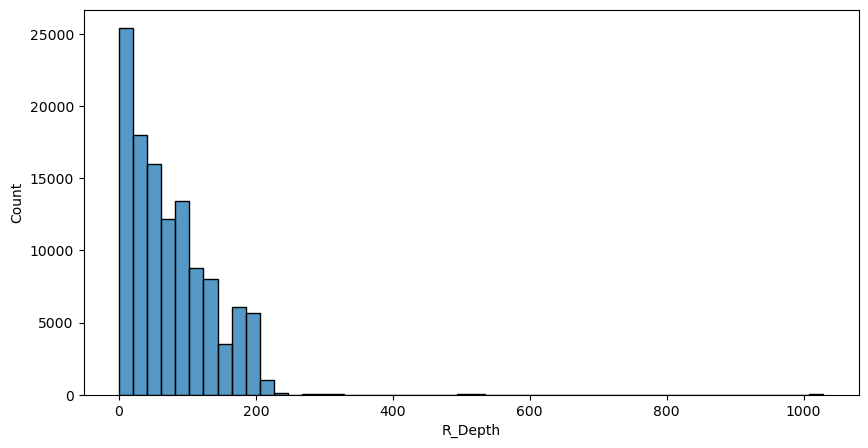

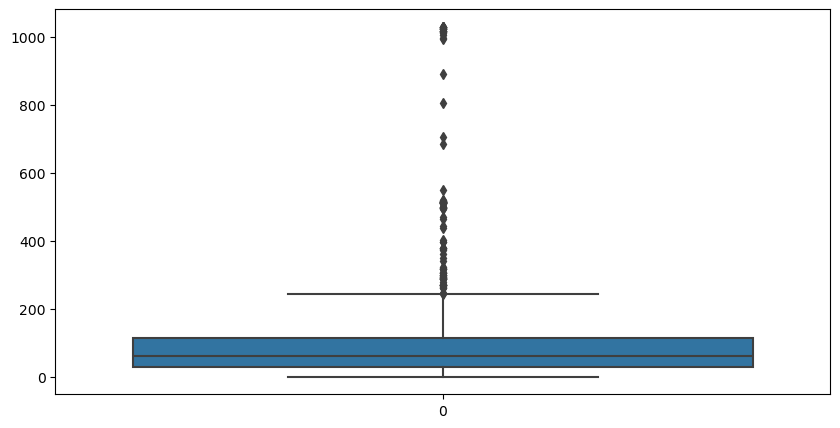

In [269]:
hist_plot(bottle_df_train['R_Depth'])
box_plot(bottle_df_train['R_Depth'])


#### R_TEMP

Here we see at least two modes in the discribution. For the missing values let's impute the uniformly distributed values between $0.25$ and $0.75$ quantiles, so that the original distribution is more or less maintained.

In [270]:
bottle_df_train['R_TEMP'].describe()

count    116779.000000
mean         12.822584
std           3.020230
min           3.590000
25%          10.170000
50%          12.540000
75%          15.030000
max          25.520000
Name: R_TEMP, dtype: float64

In [271]:
bottle_df_train['R_TEMP'].isnull().sum()

1498

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


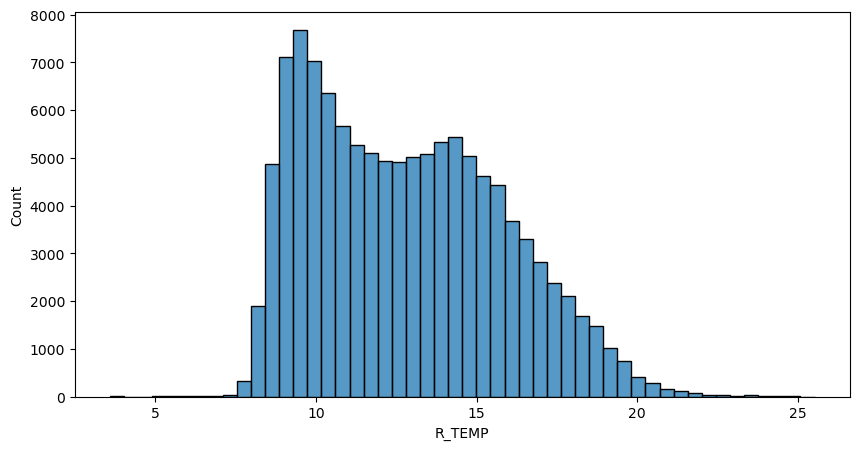

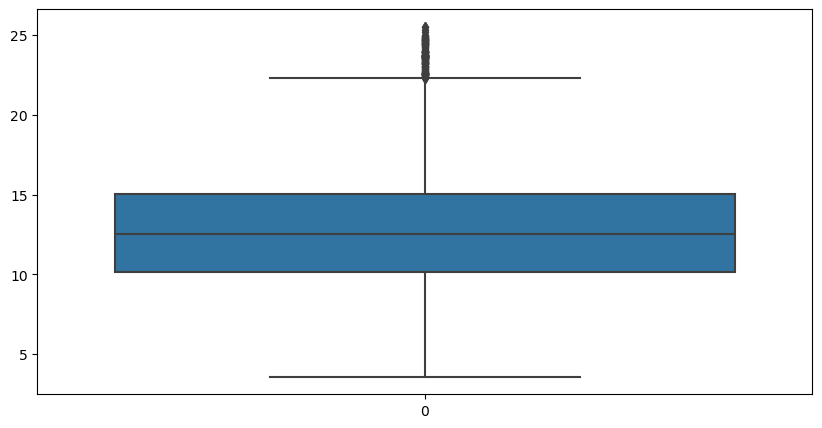

In [272]:
hist_plot(bottle_df_train['R_TEMP'])
box_plot(bottle_df_train['R_TEMP'])

In [273]:
r_temp_lower_quart = bottle_df_train['R_TEMP'].quantile(0.25)
r_temp_upper_quart = bottle_df_train['R_TEMP'].quantile(0.75)

r_temp_uniform_train = stats.uniform.rvs(loc=r_temp_lower_quart, scale=r_temp_upper_quart-r_temp_lower_quart, size=bottle_df_train['R_TEMP'].isnull().sum())
r_temp_uniform_test = stats.uniform.rvs(loc=r_temp_lower_quart, scale=r_temp_upper_quart-r_temp_lower_quart, size=bottle_df_test['R_TEMP'].isnull().sum())

bottle_df_train.loc[bottle_df_train['R_TEMP'].isnull(), 'R_TEMP'] = r_temp_uniform_train
bottle_df_test.loc[bottle_df_test['R_TEMP'].isnull(), 'R_TEMP'] = r_temp_uniform_test

In [274]:
print(bottle_df_train['R_TEMP'].isnull().sum(), bottle_df_test['R_TEMP'].isnull().sum())

0 0


In [275]:
bottle_df_train['R_TEMP'].describe()

count    118277.000000
mean         12.820163
std           3.005150
min           3.590000
25%          10.200000
50%          12.540000
75%          14.990000
max          25.520000
Name: R_TEMP, dtype: float64

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


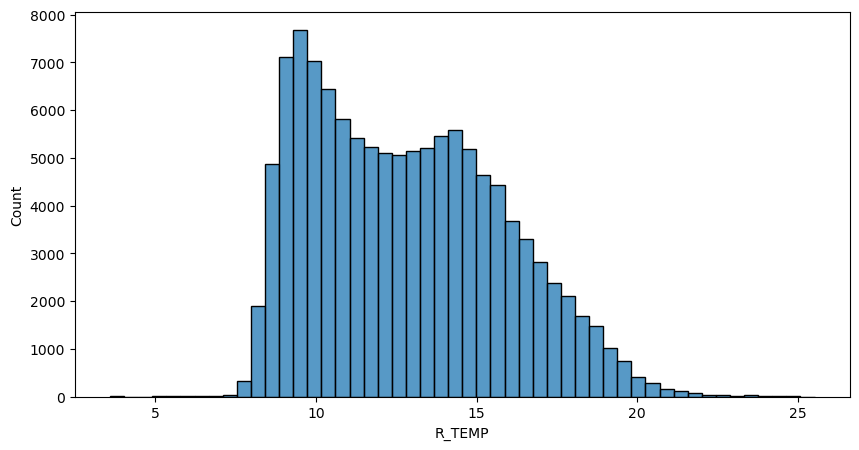

In [276]:
hist_plot(bottle_df_train['R_TEMP'])

#### R_SALINITY

Here the distribution resembles a normal one. Let's impute a mean value then, and then apply z-scaling.

In [277]:
bottle_df_train['R_SALINITY'].describe()

count    116528.000000
mean         33.509520
std           0.320389
min          29.934000
25%          33.298000
50%          33.487000
75%          33.709000
max          37.034000
Name: R_SALINITY, dtype: float64

In [278]:
bottle_df_train['R_SALINITY'].isnull().sum()

1749

c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


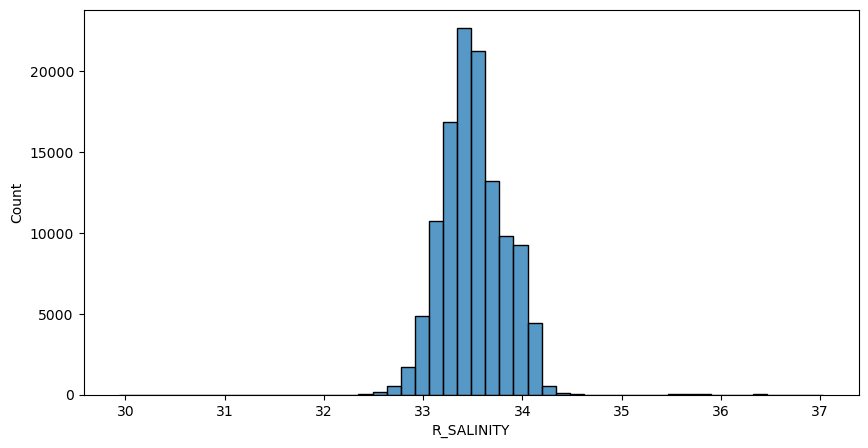

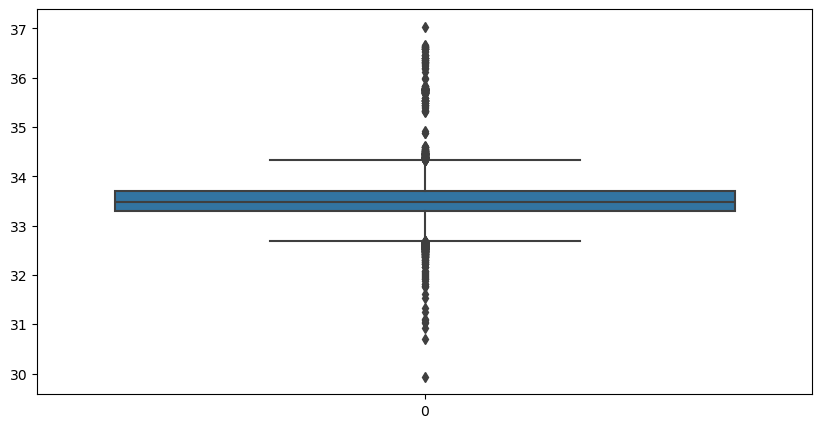

In [279]:
hist_plot(bottle_df_train['R_SALINITY'])
box_plot(bottle_df_train['R_SALINITY'])

In [280]:
salinity_mean = bottle_df_train['R_SALINITY'].mean()
salinity_std = bottle_df_train['R_SALINITY'].std()

train_null_salinity_count = bottle_df_train['R_SALINITY'].isnull().sum()
test_null_saninity_count = bottle_df_test['R_SALINITY'].isnull().sum()

bottle_df_train.loc[bottle_df_train['R_SALINITY'].isnull(), 'R_SALINITY'] = np.repeat(salinity_mean, train_null_salinity_count)
bottle_df_test.loc[bottle_df_test['R_SALINITY'].isnull(), 'R_SALINITY'] = np.repeat(salinity_mean, test_null_saninity_count)

bottle_df_train['salinity_z'] = (bottle_df_train['R_SALINITY'] - salinity_mean) / salinity_std
bottle_df_test['salinity_z'] = (bottle_df_test['R_SALINITY'] - salinity_mean) / salinity_std

In [281]:
print(bottle_df_train['R_SALINITY'].isnull().sum(), bottle_df_test['R_SALINITY'].isnull().sum())

0 0


c:\Users\shele\anaconda3\envs\calcofi\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


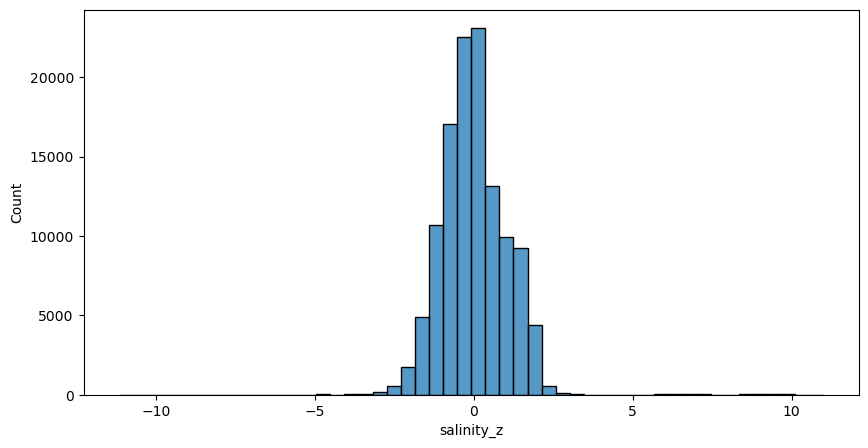

In [282]:
hist_plot(bottle_df_train['salinity_z'])